In [2]:
import numpy as np
import gurobipy as gb
import pylab as pl

from src import *

# TSDAP
## Time Dependent Activity Scheduling Problem

In [17]:
n_activities = 30
Q = 2*n_activities
eps = 1.
discretizer = TimeDiscretizer(eps)
activities = [Activity(60*i, 60*(i+1), my_tau, my_rho) for i in range(n_activities)]

V = []
q = []
for activity in activities:
    times = discretizer.discretize_activity(activity)
    V.append(dict([(i, time) for i, time in enumerate(times)]))
    q.append(dict([(i, activity.resources(time)) for i, time in enumerate(times)]))

In [18]:
%timeit sol = TEN_solve(V, activities, q, Q)
sol

79.3 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Completion time: 421.59
Resources consumed: 12.78
Nodes visited: 39

In [19]:
%timeit sol = DDD_solve(activities, Q, discretizer)
sol

121 ms ± 341 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Completion time: 421.59
Resources consumed: 12.78
Nodes visited: 39

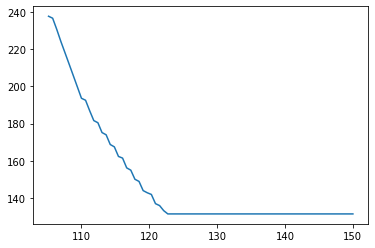

In [20]:
a = []
Qs = []
for Q in np.linspace(1.5*n_activities, 2.5*n_activities, 100):
    sol = TEN_solve(V, activities, q, Q)
    if sol is not None:
        Qs.append(Q)
        a.append(sol.completion_time())

pl.plot(Qs, a)

## Gurobi

In [ ]:
tdasp = gb.Model()
x = tdasp.addMVar((n_activities, n_steps), vtype=gb.GRB.BINARY)

In [ ]:
assignment = gb.Model()
assignment.modelSense = gb.GRB.MINIMIZE #declare mimization

# assignment.setParam('OutputFlag', 0) suppress outputs, equivalent of xpress setControl('outputlog', 0)

X = assignment.addVars( [(i,j) for i in range(4) for j in range(4)], vtype=gb.GRB.BINARY) #this way of declare vars does not allow to work with matrix multiplication (X is a tuple dict)

I = range(4)
J = range(4)

costs = np.array([[13,	4,	7, 6],
                	[1,	11,	5, 4],
                  [6,	7,	2, 8],
                  [1,	3,	5, 9]])


for i in I:
  assignment.addConstr( gb.quicksum(X[i,j] for j in J) <= 1) #quicksum is the equivalent to xp.Sum

for j in J:
  assignment.addConstr( gb.quicksum(X[i,j] for i in I) == 1 )

assignment.setObjective( 
    gb.quicksum( costs[i,j]*X[i,j]   for j in J for i in I)
    )   

assignment.optimize() #equivalent to solve() for xpress


Restricted license - for non-production use only - expires 2023-10-25
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 8 rows, 16 columns and 32 nonzeros
Model fingerprint: 0x6f06b897
Variable types: 0 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 24.0000000
Presolve time: 0.00s
Presolved: 8 rows, 16 columns, 32 nonzeros
Variable types: 0 continuous, 16 integer (16 binary)

Root relaxation: objective 1.100000e+01, 6 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.0000000   11.00000  0.00%     -    0s

Explored 1 nodes (